In [1]:
using Base: @kwdef
using Parameters: @unpack
using Makie, CairoMakie
using StatsBase

In [2]:
# Define the struct of the parameters which used in HH Equation
@kwdef struct HHPara{FT}
    cM::FT = 1.0; # the capacity of membrane
    ḡNa::FT = 120.0; ḡK::FT = 36.0; ḡL::FT = 0.3;
    ENa::FT = 50.0; EK::FT = -72.0; EL::FT = -49.0;
    V0::FT = -20.0; VSync::FT=20.0;
    tauR::FT = 0.5; tauD::FT = 8.0;
    invtr::FT = 1/tauR; invtd::FT = 1/tauD;
end

# Define the struct of the variables which used in HH Equation
@kwdef mutable struct HH{FT}
    param::HHPara = HHPara{FT}()
    N::UInt16   # the number of neurons
    v::Vector{FT} = fill(-61.77, N)    # the voltage of membrane
    m::Vector{FT} = fill(0.08,N); h::Vector{FT} = fill(0.48,N); n::Vector{FT} = fill(0.36,N); # the gating value
    r::Vector{FT} = zeros(N)
end

In [3]:
function update!(variable::HH, para::HHPara, Ie::Vector, dt)
    @unpack N, v, m, h, n, r = variable
    @unpack cM, ḡNa, ḡK, ḡL, ENa, EK, EL, invtr, invtd, V0 = para

    αn(V) = 0.01 * (V + 50)/(1 - exp(-(V + 50)/10))
    βn(V) = 0.125 * exp(-(V + 60)/80)
    αm(V) = 0.1 * (V + 35)/(1 - exp(-(V + 35)/10))
    βm(V) = 4.0 * exp(-(V + 60)/18)
    αh(V) = 0.07 * exp(-(V + 60)/20)
    βh(V) = 1/(1 + exp(-(V + 30)/10))
    @inbounds for i = 1:N
        m[i] += dt * (αm(v[i]) * (1 - m[i]) - βm(v[i]) * m[i])        
        h[i] += dt * (αh(v[i]) * (1 - h[i]) - βh(v[i]) * h[i])
        n[i] += dt * (αn(v[i]) * (1 - n[i]) - βn(v[i]) * n[i])


        v[i] += dt / cM * (Ie[i] - ḡNa * m[i]^3 * h[i] * (v[i] - ENa) - ḡK * n[i]^4 * (v[i] - EK) - ḡL * (v[i] - EL))
        r[i] += dt * ((invtr - invtd) * (1 - r[i])/(1 + exp(-v[i] + V0)) - r[i] * invtd)
    end
end

update! (generic function with 1 method)

In [4]:
function spike(V::Union{Vector{Float64}, SubArray{Float64}})
    findall(x -> x, (V[1:end-1] .< 0) .&  (V[2:end] .> 0))
end

spike (generic function with 1 method)

In [8]:
function interval_time(r::Real, N::Int64; t_max=200, max_spike = 200, dt = 0.01)
    intervals = -log.(1 .- rand(N)) ./ r;
    outsipke_time = cumsum(intervals);
    return [0:dt:t_max...], [sum(outsipke_time .< t .<= (outsipke_time .+ 0.1)) == 1 ? max_spike : 0 for t in 0:dt:t_max];
end

interval_time (generic function with 1 method)

In [5]:
dt = 0.01
T = 200
N = 100

hh = HH{Float64}(N=N)
para = HHPara{Float64}()


HHPara{Float64}(1.0, 120.0, 36.0, 0.3, 50.0, -72.0, -49.0, -20.0, 20.0, 0.5, 8.0, 2.0, 0.125)

8

In [31]:
generateIIe(0.1)

20001×1000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮         ⋱              ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0    0.0  0.0  0.0  0.0  0.0


In [30]:
function generateIIe(r)
    IIe = Array{Vector{Float64}}(undef, 10^3)
    Threads.@threads for i in 1:10^3
        IIe[i] = interval_time(r, 1000, t_max=T, max_spike=200, dt=dt)[2]
    end
    return hcat(IIe...)
end

generateIIe (generic function with 1 method)

In [32]:
hh1000 = HH{Float64}(N=1000);

for (i,j) in enumerate([0:dt:T...])    
    update!(hh1000,para, generateIIe(0.1)[:,i], dt)
end

In [10]:
V1 = Vector{Float64}(undef, length([0:dt:T...]))
avg_frequencies = Vector{Float64}(undef, length(10 .^ (-3:0.1:1)))


for (k,r) in enumerate(10 .^ (-3:0.1:1))
    frequencies = Vector{Float64}(undef, 100)
    for l in 1:100
        hh_just1 = HH{Float64}(N=1)
        _,Ie = interval_time(r,1000;)
        for (i,j) in enumerate([0:dt:T...])    
            update!(hh_just1, para, [Ie[i]], dt)
            V1[i] = hh_just1.v[1]
        end
        frequencies[l] = length(spike(V1))/T
    end

    avg_frequencies[k] = mean(frequencies)

end
println(length(spike(V1))/200)
# lines(V1)

InterruptException: InterruptException:

In [ ]:
fig2 = Figure()
ax = Axis(
    fig2[1,1],
    xscale = log10
)
scatter!(ax, 10 .^ (-3:0.1:1), avg_frequencies)
fig2

401-element Vector{Float64}:
  0.001
  0.0010232929922807535
  0.0010471285480508996
  0.001071519305237606
  0.0010964781961431851
  0.001122018454301963
  0.0011481536214968829
  0.001174897554939529
  0.001202264434617413
  0.0012302687708123812
  ⋮
  8.31763771102671
  8.511380382023766
  8.709635899560805
  8.912509381337454
  9.120108393559097
  9.33254300796991
  9.549925860214358
  9.772372209558107
 10.0

In [125]:
minimum.(Vs)

20001-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [124]:
hh.v = rand([-70:10:40...],N)

100-element Vector{Int64}:
 -20
 -10
 -60
  10
 -60
 -10
 -40
  10
  20
 -10
   ⋮
  30
 -10
 -10
 -70
  20
 -60
 -30
 -30
 -60

In [88]:
I_pre = hcat([interval_time(0.1,1000; t_max=1000)[2] for k in 1:N]...);

In [94]:
dt= 0.01
T = 200
Vs = Array{Vector{Float64}}(undef,length([0:0.01:T...]))
rs = Vector{Float64}(undef,length([0:0.01:T...]))
Ies = Vector{Int64}(undef,length([0:0.01:T...]))
# for (i,j) in enumerate([0:dt:1000...])
#     Ie = I_pre[i, :]
#     update!(hh,para,Ie,dt)
# end

_,Iall = interval_time(0.3,1000)

for (i,j) in enumerate([0:dt:T...])
    # 100 < j <= 100.1 ? Ie = [200,0] : 150 < j <= 150.1 ? Ie = [100,0] : Ie = [0,0]
    # Ie = [0]
    Ie = vcat(fill(Iall[i], N)...)
    
    # sum(Ie) > 0 && @show Ie
    update!(hh, para, Ie, dt)
    Vs[i] = [hh.v[i] for i in 1:N]
    Ies[i] = Ie[1]
end


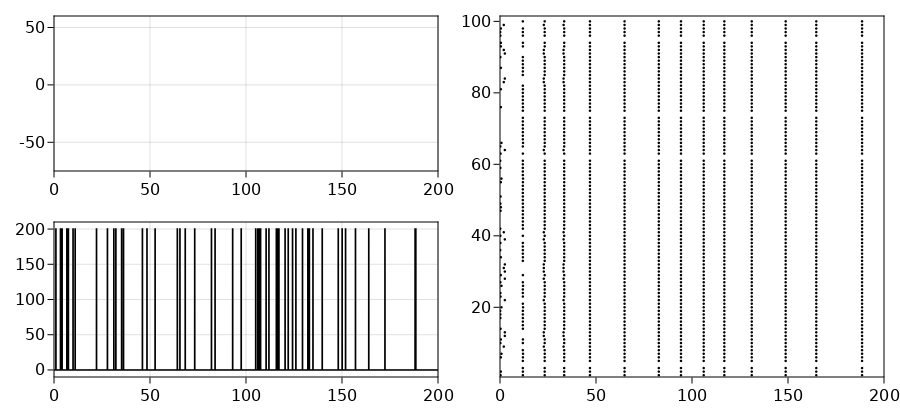

In [95]:
t = [0:dt:T...]
fig = Figure(resolution=(900,420))
ax1 = Axis(
    fig[1,1]
)
ax3 = Axis(
    fig[2,1],
    # height=150
)
ax2 = Axis(
    fig[:,2],
    # yticks = [1,2]
    # height=150
)
for (i,j) in enumerate(eachrow(hcat(Vs...)))
    # lines!(ax1, t, j)
    scatter!(ax2, t[spike(j)], [i for k in spike(j)], markersize=2.5, color=:black)
end


lines!(ax3, [0:dt:T...], Ies, color=:black)

ylims!(ax1, -75,60)
ylims!(ax2, 0.5,101.5)

hidedecorations!(ax2, ticklabels=false, ticks=false)

xlims!.([ax1,ax2,ax3], 0, T)

fig

In [103]:
spike = (V[1:trunc(Int64, T/dt)-1, :] .< 0) .& (V[2:trunc(Int64, T/dt), :] .> 0)
num_spikes = sum(spike, dims=1)
println("Num. of spikes : ", num_spikes[1])

UndefVarError: UndefVarError: `V` not defined